In [1]:
import os
import cv2
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import PIL

In [2]:
from keras.preprocessing import image

In [3]:
Types=['with_mask','without_mask']

In [4]:
data=[]  #to store images.
label=[] #to store type image stored in data.
for Type in Types:
    path=os.path.join('dataset',Type)
    for file in os.listdir(path):
        img_path=os.path.join(path,file)
        img = load_img(img_path, target_size=(224,224))
        img= img_to_array(img)
        img=preprocess_input(img)

        
        data.append(img)
        label.append(Type)

C:\ProgramData\Anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
#Converting Label to numerical values/one-hot encoding.
LB=LabelBinarizer()
label=LB.fit_transform(label)
label=to_categorical(label)

In [6]:
#coverting both data and labels to Numpy arrays for calculation.
data = np.array(data, dtype="float32")
labels = np.array(label)

In [7]:
len(data)

7553

In [8]:
#separating data for training and testing.
x_train,x_test,y_train,y_test= train_test_split(data,label,test_size=0.2)

In [9]:
x_train.shape

(6042, 224, 224, 3)

In [10]:
#data augmentation
#Generates more images from one image.
Generator1 = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [11]:
#Loading MobileNetV2 model in which the fully-connected output layers of the model used to make predictions is
#not loaded,allowing a new output layer to be added and trained

Model1=MobileNetV2(weights="imagenet",include_top = False,input_shape=(224,224,3))

In [12]:
#Creating Head of our model.
Model2=Model1.output

In [13]:
Model2=AveragePooling2D(pool_size=(7,7))(Model2)

In [14]:
Model2=Flatten(name="flatten")(Model2)

In [15]:
Model2=Dense(128, activation="relu")(Model2)

In [16]:
Model2=Dropout(0.5)(Model2)

In [17]:
Model2=Dense(2, activation="softmax")(Model2)

In [18]:
#Complete model ready to train.
Mask_Detector_Model=Model(inputs=Model1.input, outputs=Model2)

In [19]:
for layer in Model1.layers:
    layer.trainable= False

In [24]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
INIT_LR = 1e-4  # Initial learning rate
EPOCHS = 20     # Number of epochs
BS = 32         # Batch size

# Define learning rate schedule
learning_rate_schedule = ExponentialDecay(
    initial_learning_rate=INIT_LR, 
    decay_steps=EPOCHS * 6042 // BS,  # Total steps based on your dataset size
    decay_rate=0.96,  # Decay rate, can be adjusted as needed
    staircase=True
)

In [25]:
#compiling the model.
opt = Adam(learning_rate=learning_rate_schedule)
Mask_Detector_Model.compile(loss='binary_crossentropy', optimizer = opt ,metrics=["accuracy"])

In [26]:
#training our model.
Trained_Model= Mask_Detector_Model.fit(Generator1.flow(x_train,y_train, batch_size=BS),
             steps_per_epoch=len(x_train)//BS,
             validation_data=(x_test,y_test),
             validation_steps=len(x_test)//BS,
             epochs=EPOCHS)

Epoch 1/20


188/188 [==============================] - 188s 984ms/step - loss: 0.2784 - accuracy: 0.9143 - val_loss: 0.0913 - val_accuracy: 0.9788
Epoch 2/20
188/188 [==============================] - 150s 794ms/step - loss: 0.0827 - accuracy: 0.9777
Epoch 3/20
188/188 [==============================] - 142s 756ms/step - loss: 0.0641 - accuracy: 0.9800
Epoch 4/20
188/188 [==============================] - 138s 732ms/step - loss: 0.0506 - accuracy: 0.9850
Epoch 5/20
188/188 [==============================] - 140s 744ms/step - loss: 0.0455 - accuracy: 0.9870
Epoch 6/20
188/188 [==============================] - 139s 738ms/step - loss: 0.0419 - accuracy: 0.9872
Epoch 7/20
188/188 [==============================] - 138s 736ms/step - loss: 0.0366 - accuracy: 0.9903
Epoch 8/20
188/188 [==============================] - 142s 757ms/step - loss: 0.0334 - accuracy: 0.9890
Epoch 9/20
188/188 [==============================] - 139s 741ms/step - loss: 0.0328 - accuracy: 0.9900
Epoch 10/20
188/188 

In [27]:
predIdxs = Mask_Detector_Model.predict(x_test, batch_size=BS)

48/48 [==============================] - 27s 524ms/step


In [28]:
#picking indeces of max value in prediction.
predIdxs = np.argmax(predIdxs, axis=1)

In [29]:
#displaying a structured report.
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=LB.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       730
without_mask       1.00      0.99      0.99       781

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



In [32]:
#Saving our model in hard disk.
#Mask_Detector_Model.save("mask_model_working.h5", save_format="h5")
Mask_Detector_Model.save("mask_model_working.keras")

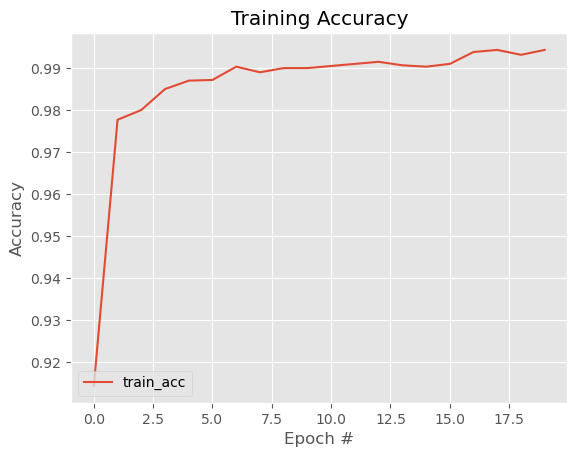

In [31]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), Trained_Model.history["accuracy"], label="train_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot_3.png")